In [1]:
# import os
# os.environ['PYSPARK_PYTHON'] = 'python'

In [2]:
import pyspark

We configure our "SparkContext" at the start - e.g. configuration options to be passed to all worker/executor nodes

In [3]:
# NOTE - we're running in 'local' context, this could be changed later to use a resource/cluster manager e.g.YARN
# conf = pyspark.SparkConf().setMaster('yarn').setAppName('YarnSparkTest')

from pyspark.sql import SparkSession

sparkSession = SparkSession.builder.master('local[*]').appName('LocalSparkSql').getOrCreate()

In [4]:
sparkSession

Read the Macbeth file from the local filesystem and count the words on each line

In [5]:
# Update if the file is somewhere else relative to the notebook
FILEPATH = ''

# e.g. if in a hadoop context, would commonly read from HDFS or S3
#FILEPATH = "hdfs://hadoop-master:9000/user/ec2-user/"

In [6]:
airportsDf = sparkSession.read.csv(FILEPATH + "airports.csv", header=True)

# Some spark dataframe operations - count and "take"
print(airportsDf.count())
airportsDf.take(5)

5741


[Row(id='1', Name='Goroka Airport', City='Goroka', Country='Papua New Guinea', iataCode='GKA', icaoCode='AYGA', latitude='-6.081689834590001', longitude='145.391998291', altitude='5282', timezone='10', dst='U', timezoneOlsonFormat='Pacific/Port_Moresby', installationType='airport', datasource='OurAirports'),
 Row(id='2', Name='Madang Airport', City='Madang', Country='Papua New Guinea', iataCode='MAG', icaoCode='AYMD', latitude='-5.20707988739', longitude='145.789001465', altitude='20', timezone='10', dst='U', timezoneOlsonFormat='Pacific/Port_Moresby', installationType='airport', datasource='OurAirports'),
 Row(id='3', Name='Mount Hagen Kagamuga Airport', City='Mount Hagen', Country='Papua New Guinea', iataCode='HGU', icaoCode='AYMH', latitude='-5.826789855957031', longitude='144.29600524902344', altitude='5388', timezone='10', dst='U', timezoneOlsonFormat='Pacific/Port_Moresby', installationType='airport', datasource='OurAirports'),
 Row(id='4', Name='Nadzab Airport', City='Nadzab', C

In [7]:
# "show" is very similar to pandas "head" - in this case the data is potentially spread around a cluster
airportsDf.show(5)

+---+--------------------+------------+----------------+--------+--------+------------------+------------------+--------+--------+---+--------------------+----------------+-----------+
| id|                Name|        City|         Country|iataCode|icaoCode|          latitude|         longitude|altitude|timezone|dst| timezoneOlsonFormat|installationType| datasource|
+---+--------------------+------------+----------------+--------+--------+------------------+------------------+--------+--------+---+--------------------+----------------+-----------+
|  1|      Goroka Airport|      Goroka|Papua New Guinea|     GKA|    AYGA|-6.081689834590001|     145.391998291|    5282|      10|  U|Pacific/Port_Moresby|         airport|OurAirports|
|  2|      Madang Airport|      Madang|Papua New Guinea|     MAG|    AYMD|    -5.20707988739|     145.789001465|      20|      10|  U|Pacific/Port_Moresby|         airport|OurAirports|
|  3|Mount Hagen Kagam...| Mount Hagen|Papua New Guinea|     HGU|    AYMH|-

### Clean the dataset by changing some datatypes

In [8]:
airportsDf.filter( airportsDf['iataCode'].isNull() ).count()

0

In [9]:
from pyspark.sql.types import DoubleType

print("original dtypes: ", airportsDf.dtypes)
print() # empty line

# change datatypes from string to double
airportsDf = airportsDf.withColumn("latitude", airportsDf["latitude"].cast(DoubleType()))
airportsDf = airportsDf.withColumn("longitude", airportsDf["longitude"].cast(DoubleType()))

print("updated dtypes: ", airportsDf.dtypes)

original dtypes:  [('id', 'string'), ('Name', 'string'), ('City', 'string'), ('Country', 'string'), ('iataCode', 'string'), ('icaoCode', 'string'), ('latitude', 'string'), ('longitude', 'string'), ('altitude', 'string'), ('timezone', 'string'), ('dst', 'string'), ('timezoneOlsonFormat', 'string'), ('installationType', 'string'), ('datasource', 'string')]

updated dtypes:  [('id', 'string'), ('Name', 'string'), ('City', 'string'), ('Country', 'string'), ('iataCode', 'string'), ('icaoCode', 'string'), ('latitude', 'double'), ('longitude', 'double'), ('altitude', 'string'), ('timezone', 'string'), ('dst', 'string'), ('timezoneOlsonFormat', 'string'), ('installationType', 'string'), ('datasource', 'string')]


**Spark Dataframe filtering - similar, though slightly different from pandas syntax**

In [10]:
# As with all spark operations, we filter the dataframe (RDD) and produce a NEW dataframe (RDD)
tropAirports = airportsDf.filter((airportsDf["latitude"] > -23) & (airportsDf["latitude"] < 23))
print(tropAirports.count())
tropAirports.show(5)

1742
+---+--------------------+------------+----------------+--------+--------+------------------+------------------+--------+--------+---+--------------------+----------------+-----------+
| id|                Name|        City|         Country|iataCode|icaoCode|          latitude|         longitude|altitude|timezone|dst| timezoneOlsonFormat|installationType| datasource|
+---+--------------------+------------+----------------+--------+--------+------------------+------------------+--------+--------+---+--------------------+----------------+-----------+
|  1|      Goroka Airport|      Goroka|Papua New Guinea|     GKA|    AYGA|-6.081689834590001|     145.391998291|    5282|      10|  U|Pacific/Port_Moresby|         airport|OurAirports|
|  2|      Madang Airport|      Madang|Papua New Guinea|     MAG|    AYMD|    -5.20707988739|     145.789001465|      20|      10|  U|Pacific/Port_Moresby|         airport|OurAirports|
|  3|Mount Hagen Kagam...| Mount Hagen|Papua New Guinea|     HGU|    A

**We can use SQL to query spark DataFrames**

First use createOrReplaceTempView to create a representation of the table in memory

In [11]:
tropAirports.createOrReplaceTempView("tropAirports")

sparkSession.sql("SELECT DISTINCT(Country) FROM tropAirports").collect()

[Row(Country='Chad'),
 Row(Country='Paraguay'),
 Row(Country='Anguilla'),
 Row(Country='British Indian Ocean Territory'),
 Row(Country='Yemen'),
 Row(Country='Senegal'),
 Row(Country='Kiribati'),
 Row(Country='Guyana'),
 Row(Country='Philippines'),
 Row(Country='Burma'),
 Row(Country='Eritrea'),
 Row(Country='Tonga'),
 Row(Country='Djibouti'),
 Row(Country='Malaysia'),
 Row(Country='Singapore'),
 Row(Country='Fiji'),
 Row(Country='Malawi'),
 Row(Country='Northern Mariana Islands'),
 Row(Country='Comoros'),
 Row(Country='Cambodia'),
 Row(Country='Saint Helena'),
 Row(Country='Rwanda'),
 Row(Country='Maldives'),
 Row(Country='Sudan'),
 Row(Country='Palau'),
 Row(Country='Turks and Caicos Islands'),
 Row(Country='France'),
 Row(Country='Sri Lanka'),
 Row(Country='Montserrat'),
 Row(Country='Taiwan'),
 Row(Country='Dominica'),
 Row(Country='British Virgin Islands'),
 Row(Country='Algeria'),
 Row(Country='Togo'),
 Row(Country='Equatorial Guinea'),
 Row(Country='Reunion'),
 Row(Country='Maca

In [12]:
sparkSession.sql('SELECT COUNT(*) FROM tropAirports WHERE Country = "Papua New Guinea"').show();

+--------+
|count(1)|
+--------+
|      51|
+--------+



**We could save the filtered table back to a filesystem or a database**

In [13]:
# Write a dataframe as csv to HDFS - similar to pandas to_csv
# tropAirports.write.format("csv").save("hdfs://hadoop-master:9000/user/ec2-user/tropAirports.csv", header=True)

**Once the dataframe is cut down to a manageable size, we may choose to convert to a pandas dataframe for further processing**

In [14]:
pdTropAirports = tropAirports.toPandas()

# pdTropAirports is a pandas Dataframe, the original was a spark dataframe
print(type(tropAirports))
print(type(pdTropAirports))

# set IATA_CODE as the index
pdTropAirports.set_index("iataCode", inplace=True)
display(pdTropAirports)

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,id,Name,City,Country,icaoCode,latitude,longitude,altitude,timezone,dst,timezoneOlsonFormat,installationType,datasource
iataCode,,,,,,,,,,,,,
GKA,1,Goroka Airport,Goroka,Papua New Guinea,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
MAG,2,Madang Airport,Madang,Papua New Guinea,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
HGU,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
LAE,4,Nadzab Airport,Nadzab,Papua New Guinea,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
POM,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TFM,6983,Telefomin Airport,Telefomin,Papua New Guinea,\N,-5.117000,141.633000,0,10,U,Pacific/Port_Moresby,airport,User
\N,6997,Palmar Airport,Santa Lucia,Peru,SLPA,-18.971666,-62.975334,1342,-4,U,America/La_Paz,airport,OurAirports
CZH,7029,Municipal,Corozal,Belize,\N,18.382200,-88.411900,40,-6,N,America/Belize,unknown,User


Country
Mexico               48
Thailand             50
Papua New Guinea     51
India                58
Venezuela            58
Philippines          59
Colombia             61
Australia            61
Indonesia            99
Brazil              109
Name: Name, dtype: int64

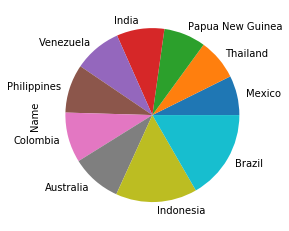

In [15]:
# top countries
topCountries = pdTropAirports.groupby('Country').count()['Name'].sort_values().tail(10)
display(topCountries)


topCountries.plot(kind="pie")